#**Text classification models trained on Toxic Comment**

- https://www.kaggle.com/abhishekmyana/toxicity-classification

- https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7


- https://github.com/susanli2016/NLP-with-Python/blob/master/Toxic%20Comments%20LSTM%20GloVe.ipynb


- https://www.kaggle.com/hongpeiyi/text-classification-with-glove-and-nn/notebook


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import seaborn as sns
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import tensorflow as tf 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Change working directory

In [3]:
import os

os.chdir('/content/drive/My Drive/FourthBrain/individual_project')
PATH = '/content/drive/My Drive/FourthBrain/individual_project'

#Data Loader

In [ ]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-10-29 12:47:25--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-29 12:47:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.86MB/s    in 2m 40s  

2021-10-29 12:50:06 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
#!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
GLOVE_DIR = "glove.6B." + str(EMBEDDING_DIM) + "d.txt"

#Load data

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
print(df_train.dtypes,'\n')
print(df_train.shape,'\n')
print(df_train.describe())

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

(159571, 8) 

               toxic   severe_toxic  ...         insult  identity_hate
count  159571.000000  159571.000000  ...  159571.000000  159571.000000
mean        0.095844       0.009996  ...       0.049364       0.008805
std         0.294379       0.099477  ...       0.216627       0.093420
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       0.000000
50%         0.000000       0.000000  ...       0.000000       0.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 6 columns]


#Data Exploratory Ananlysis
- Count number of comments for each category

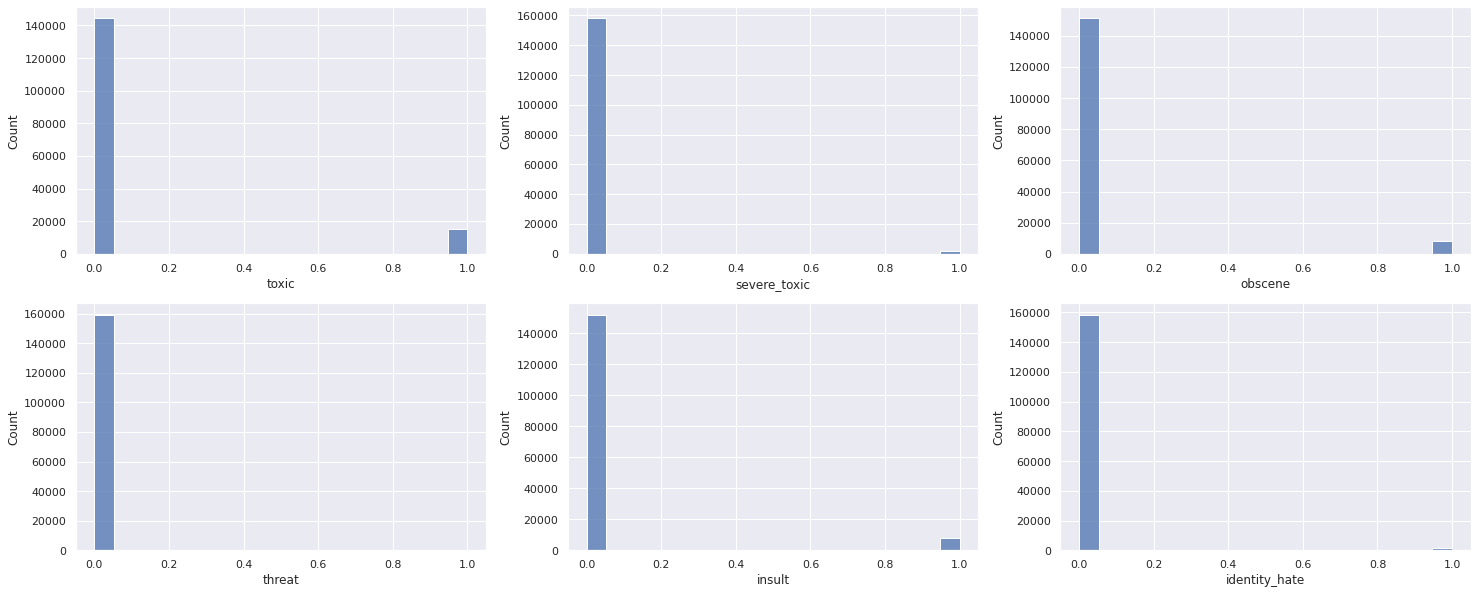

In [7]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Define the number of rows and columns you want
n_rows=2
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 10))


for i, column in enumerate(label_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(data = df_train, x = column)

#Check missing values

In [8]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

#Preprocess text

In [13]:
def preprocess_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")


In [14]:
#Clean text data
comment_text = []
for text in tqdm_notebook(df_train['comment_text'].to_list()):
  comment_text.append(preprocess_text(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/159571 [00:00<?, ?it/s]

#Vectorize text with Keras Tokenizer 

- create a tokenizer, configured to only take into account the MAX_NB_WORDS most common words.
- build the word index.
- recover the word index that was computed.

In [16]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comment_text)


In [17]:
#Converting text to a vector of word indexes 
sequences = tokenizer.texts_to_sequences(comment_text)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


#Split train and test dataset

In [18]:
#Converting this to sequences to be fed into neural network. Max seq. len is 200 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
y = df_train[label_cols].values

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [19]:
# split the training data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [20]:
# split the training data into a training set and a validation set
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [21]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12215  1290  6753   398  6299  1117]
validation:  [3079  305 1696   80 1578  288]


In [22]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [10870   128  1588  2052  4675   270  1052    21    10   107    82   187
   566     8  2384    12  1052   161  3772  2052   476   277   108  1052
   866   824   117 16800   253  6001  1023    24    17 12628   414  2806
  2856    43   360  6320  1259   140    92   476   192    10   107  4351
  4576  4675   126 14823    21    51    22   560   633   133  1052    68
   887 28559    80   165 18976    21   137    85    49 16800    11     5
  4835     2  1457  1052    62     7    10  1296   366    18   167    35
   828    15     3  2302    97 16800    21     5    15   919  1052    10
   205   104  6306    34    62  1420  7479   130   338  1648  2001    59
 45431  1770  1609   220  2221     7    84  2913 12628     1   114   277
    16    73    82    45   152  2221    93   347  2157 87972  1052    93
  1052    13   159  6233    72   189     7    21    13   114   306  1052
   137   222  3039   131 52433  4675  8739  2996  1963  2683   135    54
   128  2483  8525   415   7

#Embedding text

- use pre-trained GloVe vectors from Stanford to create an index of words mapped to known embeddings,
-  parse the data dump of pre-trained embeddings.


In [23]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set to their embedding vector
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Preparing embedding matrix.
Loading GloVe from: glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


#Plot accuracy and loss for validation

In [33]:
def print_loss_history(training_history, logscale=False):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

def print_accuracy_history(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    return

#LSTM Model using pre-trained Embedding Layer

In [25]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

- The loss function to be used is indeed the binary_crossentropy with a sigmoid activation.

- The categorical_crossentropy is not suitable for multi-label problems, because in case of the multi-label problems, the labels are not mutually exclusive. Repeat the last sentence: the labels are not mutually exclusive.

- This means that the presence of a label in the form [1,0,1,0,0,0] is correct. The categorical_crossentropy and softmax will always tend to favour one specific class, but this is not the case; just like you saw, a comment can be both toxic and obscene.

- Now imagine photos with cats and dogs inside them. What happens if we have 2 dogs and 2 cats inside a photo? Is it a dog picture or a cat picture? It is actually a "both" picture! We definitely need a way to specify that multiple labels are pertained/related to a photo/label.

- The rationale for using the binary_crossentropy and sigmoid for multi-label classification resides in the mathematical properties, in that each output needs to be treated as in independent Bernoulli distribution.

- Therefore, the only correct solution is BCE + 'sigmoid'.

In [26]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [27]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

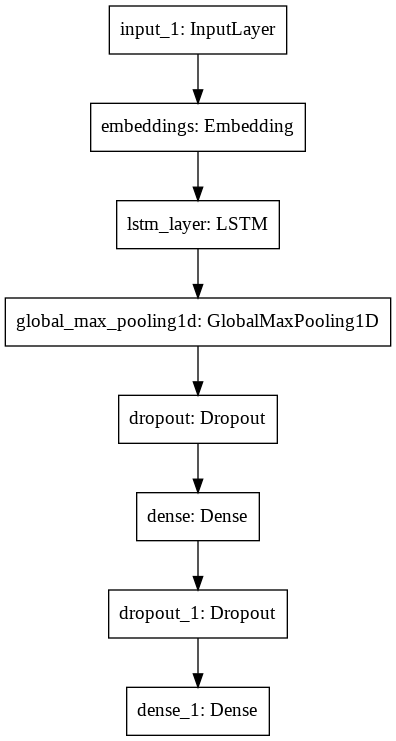

In [28]:
tf.keras.utils.plot_model(model)

##Train LSTM model

In [35]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0609 - accuracy: 0.9936 - val_loss: 0.0599 - val_accuracy: 0.9945
Epoch 2/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0575 - accuracy: 0.9936 - val_loss: 0.0604 - val_accuracy: 0.9945
Epoch 3/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0548 - accuracy: 0.9937 - val_loss: 0.0584 - val_accuracy: 0.9945
Epoch 4/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0524 - accuracy: 0.9933 - val_loss: 0.0588 - val_accuracy: 0.9944
Epoch 5/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0502 - accuracy: 0.9933 - val_loss: 0.0595 - val_accuracy: 0.9942
Epoch 6/10
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0484 - accuracy: 0.9923 - val_loss: 0.0612 - val_accuracy: 0.9944
Epoch 7/10
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0466 - accuracy: 0.9928 -

##Evaluate the LSTM model

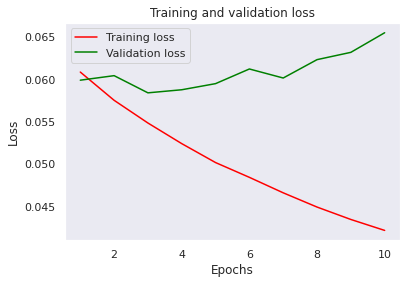

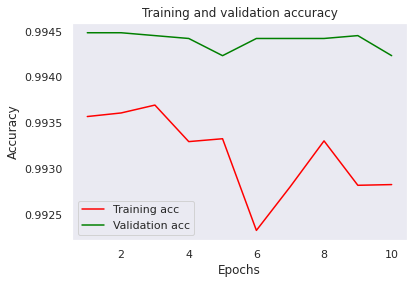

In [36]:
print_loss_history(history)
print_accuracy_history(history)

#Predict toxic comments from test data

In [ ]:
test_sequences = tokenizer.texts_to_sequences(df_test['comment_text']) 
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

test_labels =  pd.read_csv('test_labels.csv')
test_labels =  test_labels.iloc[:,1:]
#test_labels = to_categorical(np.asarray(test_labels))


Test accuracy with RNN: [[7.96721160e-01 3.38684507e-02 4.48564768e-01 1.62335094e-02
  4.80266571e-01 5.57642095e-02]
 [1.00257486e-01 1.46095816e-03 2.21086498e-02 6.27904898e-04
  4.13953252e-02 2.00101128e-03]
 [1.19847558e-01 4.45641531e-03 4.54119220e-02 1.15128560e-03
  6.57942593e-02 2.59156828e-03]
 ...
 [2.94272229e-02 1.16779840e-04 4.07120259e-03 1.58710958e-04
  8.65675975e-03 8.17191612e-04]
 [4.64337170e-02 1.80858318e-04 3.79697978e-03 3.70020600e-04
  1.12189036e-02 7.22059514e-03]
 [5.67981541e-01 1.56876203e-02 2.17786998e-01 4.64251125e-03
  2.89836586e-01 1.16103292e-02]]


In [ ]:
y_pred = model.predict(test_data)
y_pred[0]

array([0.79672116, 0.03386845, 0.44856477, 0.01623351, 0.48026657,
       0.05576421], dtype=float32)

In [ ]:
#class_labels=[labels[i] for i,prob in enumerate(y_pred) if prob > 0.5]
#class_labels
for i,prob in enumerate(y_pred[0]):
  if prob > 0.5:
    print(label_cols[i])


toxic


In [ ]:
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1,0)

In [ ]:
y_pred[0]

array([1, 0, 0, 0, 0, 0])

#LSTM Model with training your own embedding

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         12800000  
_________________________________________________________________
lstm_layer (LSTM)            (None, None, 60)          45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

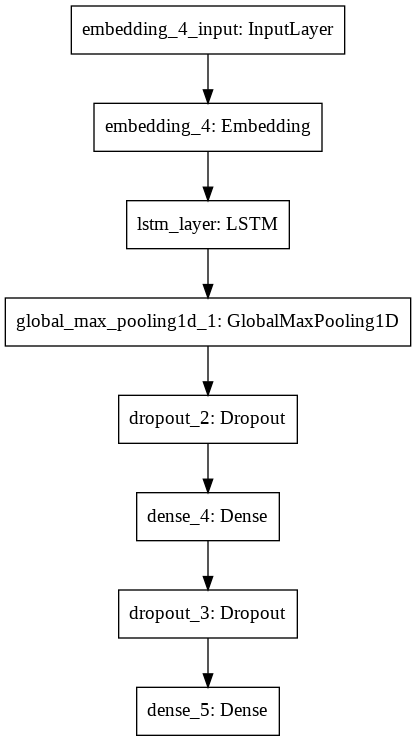

In [45]:
from tensorflow.keras.models import Sequential

model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, 128))
model2.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model2.add(GlobalMaxPool1D())  
model2.add(Dropout(0.1))
model2.add(Dense(50, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(6, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

tf.keras.utils.plot_model(model2)

In [48]:
print('Training progress:')
history2 = model2.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/10
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0399 - accuracy: 0.9381 - val_loss: 0.0615 - val_accuracy: 0.9889
Epoch 2/10
3990/3990 [==============================] - 57s 14ms/step - loss: 0.0327 - accuracy: 0.9152 - val_loss: 0.0659 - val_accuracy: 0.9806
Epoch 3/10
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0266 - accuracy: 0.8191 - val_loss: 0.0782 - val_accuracy: 0.9839
Epoch 4/10
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0216 - accuracy: 0.7470 - val_loss: 0.0836 - val_accuracy: 0.9287
Epoch 5/10
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0178 - accuracy: 0.6963 - val_loss: 0.0936 - val_accuracy: 0.6826
Epoch 6/10
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0148 - accuracy: 0.7606 - val_loss: 0.1107 - val_accuracy: 0.8856
Epoch 7/10
3990/3990 [==============================] - 57s 14ms/step - loss: 0.0125 - accuracy: 0.7980 -

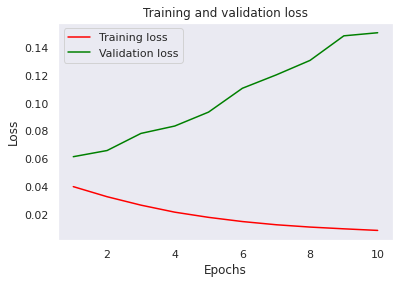

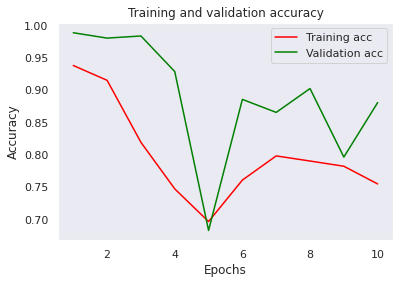

In [49]:
print_loss_history(history2)
print_accuracy_history(history2)

#1D CNN Model with pre-trained embedding

Define a 1D CNN model.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (N

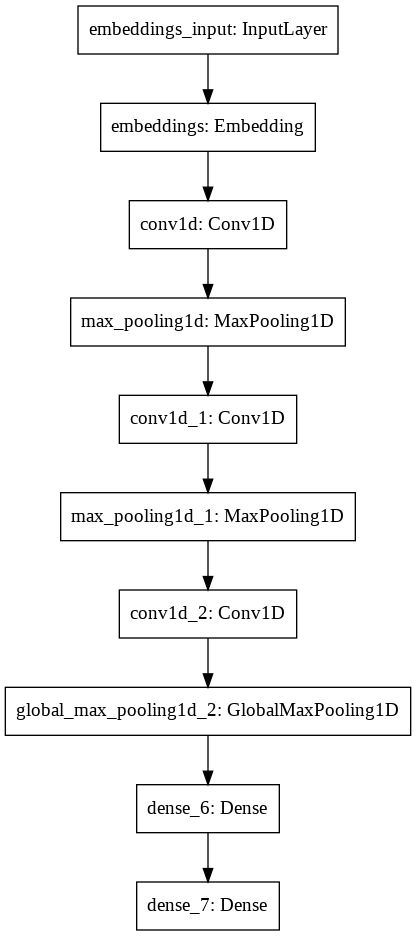

In [50]:
print('Define a 1D CNN model.')

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(6, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model3.summary()

tf.keras.utils.plot_model(model3)

In [53]:
print('Training progress:')
history3 = model3.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/20
3990/3990 [==============================] - 17s 4ms/step - loss: 0.0619 - accuracy: 0.9853 - val_loss: 0.0686 - val_accuracy: 0.9945
Epoch 2/20
3990/3990 [==============================] - 18s 4ms/step - loss: 0.0563 - accuracy: 0.9849 - val_loss: 0.0685 - val_accuracy: 0.9944
Epoch 3/20
3990/3990 [==============================] - 18s 4ms/step - loss: 0.0517 - accuracy: 0.9682 - val_loss: 0.0728 - val_accuracy: 0.9426
Epoch 4/20
3990/3990 [==============================] - 17s 4ms/step - loss: 0.0473 - accuracy: 0.9556 - val_loss: 0.0775 - val_accuracy: 0.9442
Epoch 5/20
3990/3990 [==============================] - 18s 4ms/step - loss: 0.0440 - accuracy: 0.9558 - val_loss: 0.0761 - val_accuracy: 0.9794
Epoch 6/20
3990/3990 [==============================] - 18s 4ms/step - loss: 0.0412 - accuracy: 0.9445 - val_loss: 0.0814 - val_accuracy: 0.8090
Epoch 7/20
3990/3990 [==============================] - 17s 4ms/step - loss: 0.0387 - accuracy: 0.9107 - val_lo

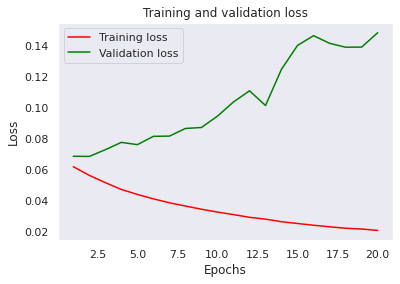

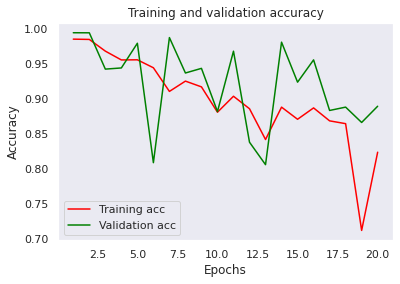

In [54]:
print_loss_history(history3)
print_accuracy_history(history3)

#1D CNN model with training your own embedding

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         12800000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         82048     
_________

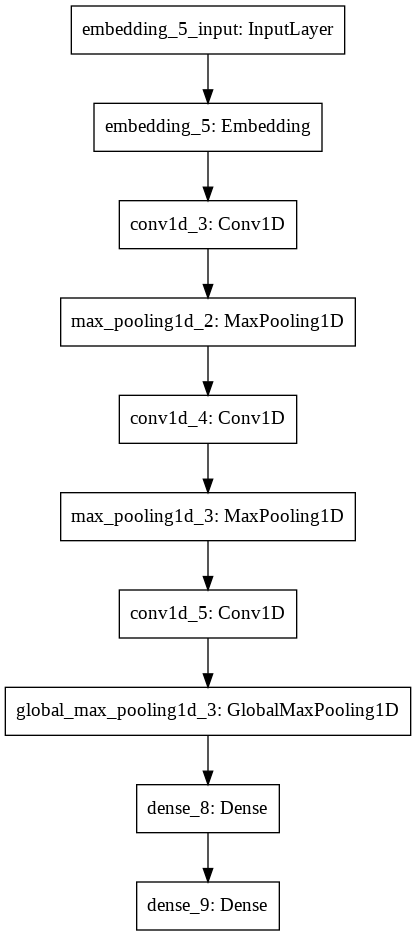

In [55]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
model4 = Sequential()
model4.add(Embedding(MAX_NB_WORDS, 128))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(MaxPooling1D(5))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(MaxPooling1D(5))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(6, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model4.summary()

tf.keras.utils.plot_model(model4)

In [58]:
print('Training progress:')
history4 = model4.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/10
3990/3990 [==============================] - 33s 8ms/step - loss: 0.0377 - accuracy: 0.9223 - val_loss: 0.0644 - val_accuracy: 0.9941
Epoch 2/10
3990/3990 [==============================] - 33s 8ms/step - loss: 0.0311 - accuracy: 0.8389 - val_loss: 0.0750 - val_accuracy: 0.9480
Epoch 3/10
3990/3990 [==============================] - 32s 8ms/step - loss: 0.0264 - accuracy: 0.6292 - val_loss: 0.0841 - val_accuracy: 0.9505
Epoch 4/10
3990/3990 [==============================] - 32s 8ms/step - loss: 0.0220 - accuracy: 0.7363 - val_loss: 0.0902 - val_accuracy: 0.9626
Epoch 5/10
3990/3990 [==============================] - 33s 8ms/step - loss: 0.0188 - accuracy: 0.6797 - val_loss: 0.0910 - val_accuracy: 0.3339
Epoch 6/10
3990/3990 [==============================] - 33s 8ms/step - loss: 0.0159 - accuracy: 0.5852 - val_loss: 0.1054 - val_accuracy: 0.8472
Epoch 7/10
3990/3990 [==============================] - 32s 8ms/step - loss: 0.0135 - accuracy: 0.7886 - val_lo

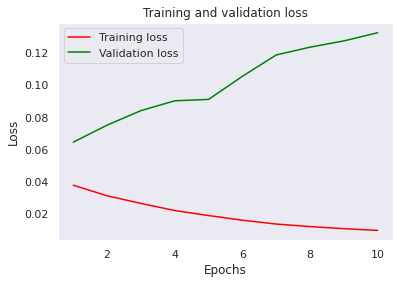

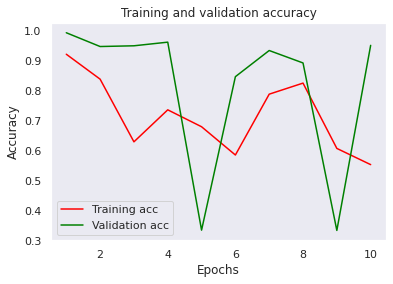

In [59]:
print_loss_history(history4)
print_accuracy_history(history4)

#All 1D CNN pre-trained embedding and training your own embedding, LSTM Model with training your own embedding are overfittting 